This notebook demonstrates projection of point cloud at the viewpoint of nearby panorma as rasters, and export clipped rasters.

In [ ]:
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
# from lidar.point_cloud_processings import remove_noise, get_rotation_matrix, project_lidar_perspective, project_lidar_equirectangular
import geopandas as gpd
import pdal
import glob
import pyproj

### Load building points

In [3]:
building_points_file=r'/home/ubuntu/lavender_floor_height/output/Final_Wagga_training_samples_pano_metadata.geojson'
gdf_building_points=gpd.read_file(building_points_file)
gdf_building_points=gdf_building_points[gdf_building_points["USAGE"]=="Residential"].reset_index(drop=True)
gdf_building_points.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,LTP_x_m,LTP_y_m,LTP_z_m,Roll_deg,Pitch_deg,Heading_deg,FRAMEID,IMGID,distance,geometry
0,Brick,1,Residential,1,ROBERT,28 SPRING STREET,128.806974,6.9281,2.1277,-9999.0000,...,532008.2113,6114398.715,180.0966,-0.343451,-1.215830,166.445703,1739405253-0000003052,0504_1739405253-0000003052_Panorama_20250213_G...,18.901973,POINT (532026.09 6114393.029)
1,Brick,2,Residential,1,ROBERT,9 NORTH PARADE,154.755345,6.5745,-9999.0000,-9999.0000,...,532188.2897,6114311.309,180.7244,1.000789,-0.061197,-101.069299,1739405253-0000003272,0505_1739405253-0000003272_Panorama_20250213_G...,19.948013,POINT (532190.774 6114329.585)
2,Brick,1,Residential,2,ROBERT,4 THOMAS STREET,294.580219,6.8309,2.1030,1.1167,...,531982.4553,6114575.693,180.1386,0.110114,-0.999721,19.648854,1739332533-0000003367,0448_1739332533-0000003367_Panorama_20250212_G...,21.276532,POINT (531961.945 6114566.928)
3,Brick,1,Residential,1,ROBERT,40 SLOCUM STREET,290.352249,6.2612,1.6366,0.5181,...,532022.1804,6115201.164,180.9586,-0.614706,-0.105462,-71.002953,1739332533-0000006081,0274_1739332533-0000006081_Panorama_20250212_G...,12.458696,POINT (532025.932 6115188.022)
4,Brick,1,Residential,1,ROBERT,13 EVANS STREET,205.000441,5.7174,1.1566,-9999.0000,...,532032.1509,6114917.196,180.3083,-0.504672,1.289210,-159.715010,1739332533-0000007076,0344_1739332533-0000007076_Panorama_20250212_G...,27.159260,POINT (532057.001 6114925.415)


### Convert heading angles

In [4]:
gdf_building_points['Heading_deg'] *= -1
gdf_building_points.loc[gdf_building_points['Heading_deg'] < 0, 'Heading_deg'] += 360

In [5]:
las_files_folder = r"/mnt/floorheightvolume/lidar_Wagga/clipped/"

## Test with one building example

### Identify corresponding las file

In [6]:
# building_ufi=1271
# gdf_building_points[gdf_building_points['UFI']==building_ufi]

In [7]:
i=90
building_ufi=gdf_building_points.iloc[i]['UFI']
las_file_path=glob.glob(las_files_folder+'*'+'_UFI_'+str(building_ufi)+'.las')[0]
las_file_path

'/mnt/floorheightvolume/lidar_Wagga/clipped/gnaf_GANSW706136463_UFI_1271.las'

In [8]:
def project_las_to_equirectangular(
    input_las,
    camera_pos=[0, 0, 0],
    camera_angles=[0,0,0],
    width=2048,
    height=1024
):
    """
    Projects LAS to equirectangular maps with intrinsic XYZ rotation.
    Returns:
        rgb_raster (np.uint8): (H,W,3) RGB image
        z_raster (np.float32): (H,W) elevation map
        depth_raster (np.float32): (H,W) depth map
        class_raster (np.float32): (H,W) classification map
    """
    # --- Data Loading ---
    pipeline = pdal.Reader.las(filename=input_las).pipeline()
    pipeline.execute()
    points = pipeline.arrays[0]
    x, y, z = points["X"], points["Y"], points["Z"]
    rgb = np.vstack([points["Red"], points["Green"], points["Blue"]]).T/256
    classification = points["Classification"].astype(np.uint8)
    print("RGB min/max:", rgb.min(axis=0), rgb.max(axis=0))

    # --- Coordinate Transformation ---
    # Convert angles to radians
    yaw_rad = np.radians(camera_angles[0])
    pitch_rad = np.radians(camera_angles[1])
    roll_rad = np.radians(camera_angles[2])

    # Translate to camera origin
    x -= camera_pos[0]
    y -= camera_pos[1]
    z -= camera_pos[2]

    # Intrinsic XYZ rotation matrices
    R_roll = np.array([
        [1, 0, 0],
        [0, np.cos(roll_rad), -np.sin(roll_rad)],
        [0, np.sin(roll_rad), np.cos(roll_rad)]
    ])
    R_pitch = np.array([
        [np.cos(pitch_rad), 0, np.sin(pitch_rad)],
        [0, 1, 0],
        [-np.sin(pitch_rad), 0, np.cos(pitch_rad)]
    ])
    R_heading = np.array([
        [np.cos(yaw_rad), -np.sin(yaw_rad), 0],
        [np.sin(yaw_rad), np.cos(yaw_rad), 0],
        [0, 0, 1]
    ])
    R_total = R_heading @ R_pitch @ R_roll  # Intrinsic XYZ order

    # Apply rotation
    coords = np.vstack([x, y, z])
    coords_local = R_total @ coords

    # Transform to camera coordinate convention:
    #    LiDAR's +Z (up) should become camera's +Y (down)
    #    LiDAR's +Y (north) should become camera's -Z (forward)
    x_cam = coords_local[0]
    y_cam = -coords_local[2]  # LiDAR Z (up) -> Camera Y (down)
    z_cam = coords_local[1]   # LiDAR Y (north) -> Camera Z (forward)

    # --- Equirectangular Projection ---
    r = np.sqrt(x_cam**2 + y_cam**2 + z_cam**2)  # Depth
    theta = np.arctan2(x_cam, z_cam)               # Azimuth
    phi = np.arccos(-y_cam / r)                       # flip Zenith

    print("Theta range:", np.min(theta), np.max(theta))
    print("Phi range (deg):", np.degrees(np.min(phi)), np.degrees(np.max(phi)))
    # Pixel coordinates
    u = (theta + np.pi) / (2 * np.pi) * width
    v = phi / np.pi * height
    u_idx = np.round(u).astype(int) % width
    v_idx = np.clip(np.round(v).astype(int), 0, height - 1)

    # --- Rasterization ---
    rgb_raster = np.zeros((height, width, 3), dtype=np.uint8)
    z_raster = np.full((height, width), np.nan, dtype=np.float32)
    depth_raster = np.full((height, width), np.inf)
    class_raster = np.zeros((height, width), dtype=np.uint8)

    # rgb_raster[v_idx, u_idx] = rgb
    # z_raster[v_idx, u_idx] = z + camera_pos[2]
    # depth_raster[v_idx, u_idx] = r

    # Rasterize closest points
    for i in range(len(u_idx)):
        row, col = v_idx[i], u_idx[i]
        if r[i] < depth_raster[row, col]:
            depth_raster[row, col] = r[i]
            rgb_raster[row, col] = rgb[i]
            z_raster[row, col] = z[i] + camera_pos[2]
            class_raster[row, col] = classification[i]
            
    # Cleanup
    z_raster[depth_raster == np.inf] = np.nan
    class_raster[depth_raster == np.inf] = 0
    
    return rgb_raster, z_raster, depth_raster, class_raster


In [9]:
gdf_building_points.columns

Index(['WALL_M', 'STEPS', 'USAGE', 'STOREYS', 'ASSESSOR', 'address', 'Area_1',
       'PMF', 'Dep_500', 'Dep_200', 'Dep_100', 'Dep_50', 'Dep_20', 'Dep_10',
       'Ground_Lev', 'Floor_Leve', 'AGE', 'UFI', 'ZONE_DESCR', 'Floor_height',
       'Ground_surveyed', 'cluster', 'Ground_Level_bin', 'index_right', 'ucid',
       'LONGITUDE', 'LATITUDE', 'ELEVATION', 'Frame_filename', 'dRMS',
       'Systemtime_sec', 'Frame_index', 'LTP_x_m', 'LTP_y_m', 'LTP_z_m',
       'Roll_deg', 'Pitch_deg', 'Heading_deg', 'FRAMEID', 'IMGID', 'distance',
       'geometry'],
      dtype='object')

### Reproject trajectory coordinates to match lidar points

In [12]:
transformer = pyproj.Transformer.from_crs(
    "EPSG:7844",  # GDA2020 geographic (lat/lon)
    "EPSG:7855",      # MGA Zone 55 (EPSG:7855)
    always_xy=True
)
# lat, lon, elev = [gdf_building_points.iloc[i]['LATITUDE'],gdf_building_points.iloc[i]['LONGITUDE'],gdf_building_points.iloc[i]['ELEVATION']]
lat, lon, elev = [gdf_building_points.iloc[i]['LATITUDE'],gdf_building_points.iloc[i]['LONGITUDE'],gdf_building_points.iloc[i]['LTP_z_m']] # TODO: confirming lidar data is in AHD
x_proj, y_proj = transformer.transform(lon, lat)  # lon, lat order
camera_pos_proj = [x_proj, y_proj, elev]
camera_pos_proj

[531981.7644594751, 6114520.6306446185, np.float64(180.327)]

In [14]:
camera_angles=[gdf_building_points.iloc[i]['Heading_deg'], gdf_building_points.iloc[i]['Pitch_deg'], gdf_building_points.iloc[i]['Roll_deg']]
camera_angles

[np.float64(281.856283), np.float64(-0.249928), np.float64(1.843393)]

### Project the point cloud as rasters

In [ ]:
rgb, z, depth, classification = project_las_to_equirectangular(
    input_las=las_file_path,
    camera_pos=camera_pos_proj,
    camera_angles=camera_angles,
    width=2048,  # Reduced for faster testing
    height=1024
)

RGB min/max: [0. 0. 0.] [255. 255. 255.]
Theta range: -2.13943346152298 -0.8988441179617334
Phi range (deg): 81.43736836151186 101.94278462381118


### Visualise rasters

Text(0.5, 1.0, 'RGB Panorama')

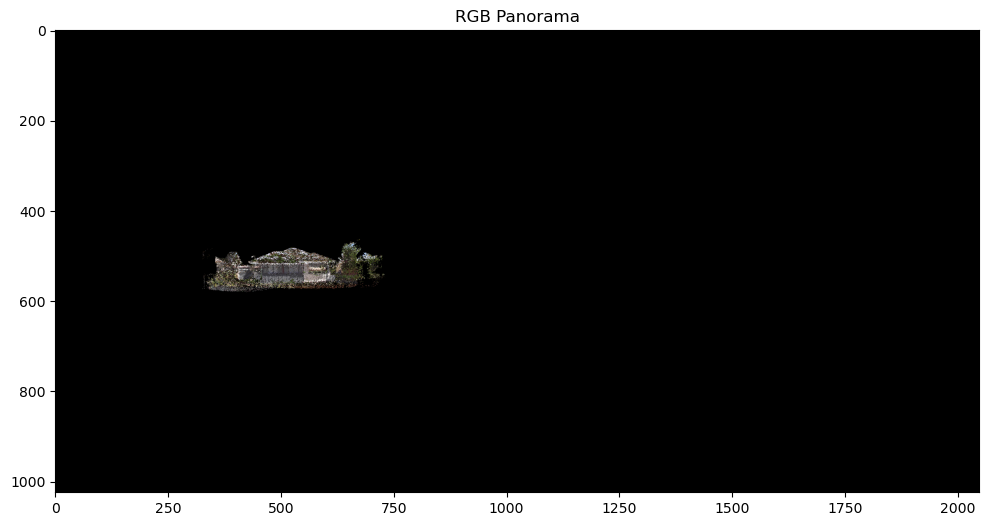

In [132]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
# RGB plot
axes.imshow(rgb)
axes.set_title("RGB Panorama")

Text(0.5, 1.0, 'Elevation Map (Z)')

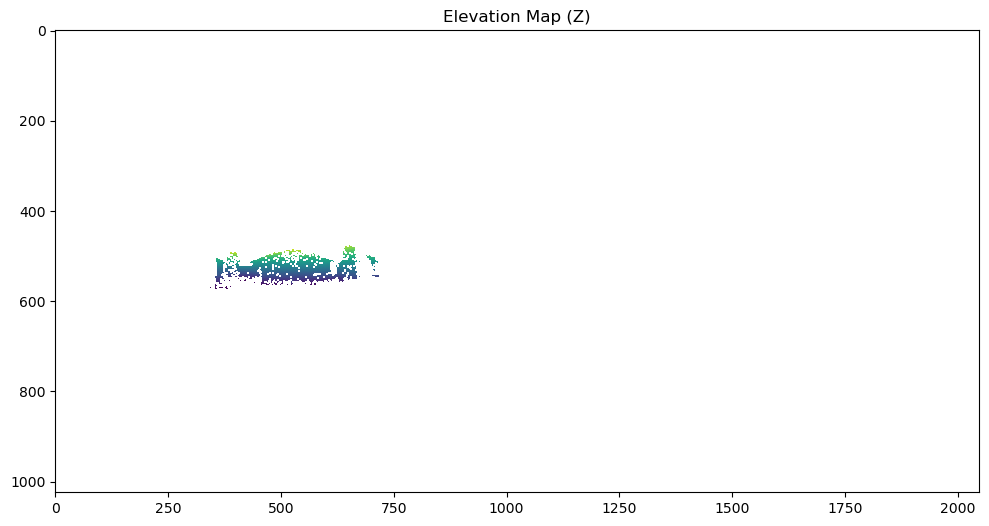

In [131]:
# Elevation plot
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.imshow(z, cmap=cm.viridis)
axes.set_title("Elevation Map (Z)")

Text(0.5, 1.0, 'Depth Map')

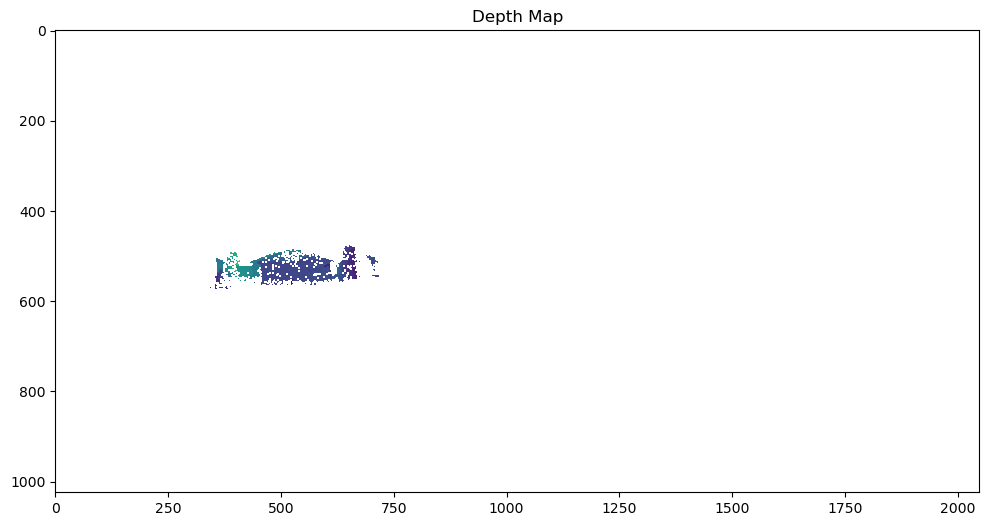

In [130]:
# Depth plot
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.imshow(depth, cmap=cm.viridis)
axes.set_title("Depth Map")

Text(0.5, 1.0, 'Classification Map')

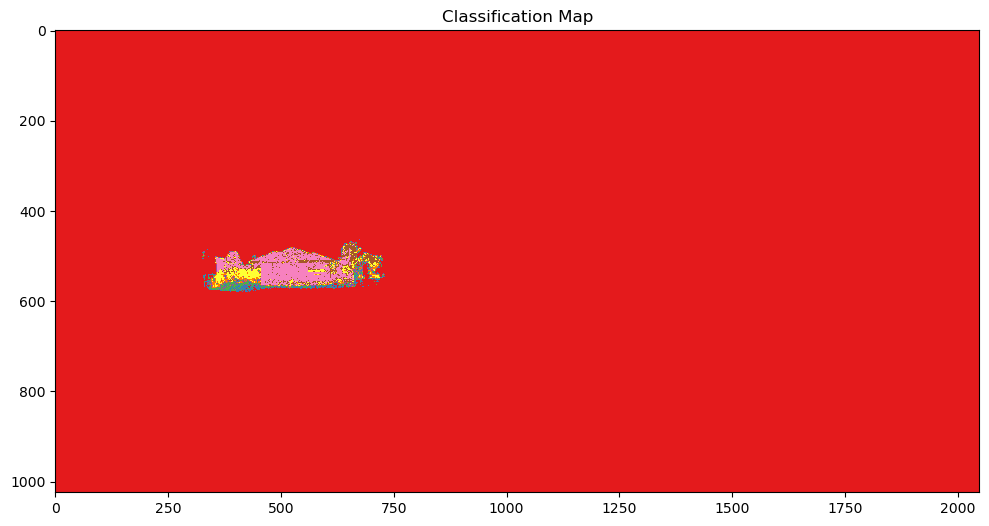

In [140]:
# Classification plot
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.imshow(classification, cmap=cm.Set1,interpolation=None)
axes.set_title("Classification Map")

### Clip projected rasters

### Save rasters

## Batch apply to all buildings with nearby panoramas